In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

In [407]:
pd.__version__

'1.4.4'

In [2]:
DATADIR = Path('data')

In [3]:
print(os.listdir(DATADIR))

['df_location_ratio.csv', 'df_phq9.csv', 'df_baseline_phq9.csv', 'df_passive_mobility_features.csv', 'df_demographics.csv', 'data_analysis.ipynb']


# Preparing the Data for Training

## Reading the Data

In [234]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,phq9Date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0


In [235]:
demographics = pd.read_csv(DATADIR / 'df_demographics.csv')
demographics.head()

,Unnamed: 0,participant_id,working,income_satisfaction,income_lastyear,age,startdate,study,gen_Female,gen_Male,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,213,EN00033,1.0,3.0,6.0,52.0,2016-08-12 12:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
1,214,EN00034,1.0,3.0,4.0,32.0,2016-08-12 12:58:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
2,215,EN00035,0.0,2.0,2.0,57.0,2016-08-12 15:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
3,216,EN00036,1.0,3.0,3.0,55.0,2016-08-13 10:24:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
4,217,EN00037,0.0,2.0,6.0,34.0,2016-08-15 09:04:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0


In [239]:
demographics.participant_id.unique()
phq9.participant_id.sort_values().unique()

array(['BLUE-00048', 'BLUE-00050', 'BLUE-00051', 'BLUE-00052',
       'BLUE-00053', 'BLUE-00054', 'BLUE-00055', 'BLUE-00058',
       'BLUE-00060', 'BLUE-00062', 'BLUE-00063', 'BLUE-00064',
       'BLUE-00065', 'BLUE-00066', 'BLUE-00067', 'BLUE-00070',
       'BLUE-00072', 'BLUE-00077', 'BLUE-00079', 'BLUE-00082',
       'BLUE-00086', 'BLUE-00088', 'BLUE-00090', 'BLUE-00092',
       'BLUE-00093', 'BLUE-00094', 'BLUE-00096', 'BLUE-00097',
       'BLUE-00100', 'BLUE-00101', 'BLUE-00102', 'BLUE-00104',
       'BLUE-00105', 'BLUE-00107', 'BLUE-00108', 'BLUE-00111',
       'BLUE-00112', 'BLUE-00113', 'BLUE-00114', 'BLUE-00115',
       'BLUE-00119', 'BLUE-00120', 'BLUE-00121', 'BLUE-00122',
       'BLUE-00123', 'BLUE-00125', 'BLUE-00126', 'BLUE-00128',
       'BLUE-00129', 'BLUE-00132', 'BLUE-00133', 'BLUE-00142',
       'BLUE-00144', 'BLUE-00146', 'BLUE-00148', 'BLUE-00149',
       'BLUE-00157', 'BLUE-00159', 'BLUE-00162', 'BLUE-00164',
       'BLUE-00165', 'BLUE-00166', 'BLUE-00168', 'BLUE-

In [6]:
locations = pd.read_csv(DATADIR / 'df_location_ratio.csv')
locations.head()

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,EN00039,2016-09-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EN00039,2016-09-17,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EN00039,2016-11-11,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EN00039,2016-11-13,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EN00039,2016-11-14,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cleaning a bit More

In [7]:
phq9.rename(columns={'phq9Date': 'date'}, inplace=True)

In [57]:
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff,has_phq9
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN,True
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN,True
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0,True
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0,True
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0,True


## Joining the Tables

In [568]:
from data_processing import *
import data_processing as dp
import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately

def train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, return_csv=False):

    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined
    
    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15, random_state=SEED,
                                                                           test_take_first=TEST_TAKE_FIRST)
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED, stratify=y)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    print()


    if TYPE == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f'Train score:', train_score)
        print(f'Test score:', test_score)
        
        return train_score, test_score
    elif TYPE == 'classification':

        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        y_full = np.concatenate((y_train, y_test))
        random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # train_acc = 100 * model.score(x_train, y_train)
        # test_acc = 100 * model.score(x_test, y_test)
        # print(f'Train set accuracy: {train_acc:.2f}%') 
        # print(f'Test set accuracy:  {test_acc:.2f}%')
        print(f'Random full accuracy: {random_acc:.2f}%')

        figs, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        print('Train set:')
        train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0])

        print('Test set:')
        test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1])
        
        return train_bal, test_bal

### Experiment with Taking N First Rows from Test Participants

In [570]:
csv = train(return_csv=True)
csv.groupby('participant_id').size()

participant_id
EN00035    4
EN00039    4
EN00040    1
EN00041    6
EN00046    8
          ..
ES05054    7
ES05059    5
ES05060    3
ES05062    6
ES05073    5
Length: 285, dtype: int64

***** TAKE FIRST N=0 *****
Train set shape: (969, 61)
Test set shape: (192, 61)
Ratio: 83.46%/16.54%

Random full accuracy: 17.92%
Train set:
Mean accuracy: 94.118%
Balanced accuracy: 94.597%
Test set:
Mean accuracy: 26.562%
Balanced accuracy: 24.081%
***** TAKE FIRST N=1 *****
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
Train set shape: (1012, 61)
Test set shape: (149, 61)
Ratio: 87.17%/12.83%

Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.269%
Balanced accuracy: 94.662%
Test set:
Mean accuracy: 48.322%
Balanced accuracy: 47.805%
***** TAKE FIRST N=2 *****
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
Train set shape: (1047, 61)
Test set shape: (114, 61)
Ratio: 90.18%/9.82%

Random full accuracy: 18.35%
Train set:
Mean accuracy: 94.174%
Balanced accuracy: 94.547%
Test set:
Mean accuracy: 43.860%
Balanced accuracy: 46.009%
***** TAKE FIRST N=3 *****
After test_take_first=3, have 93.44% (2

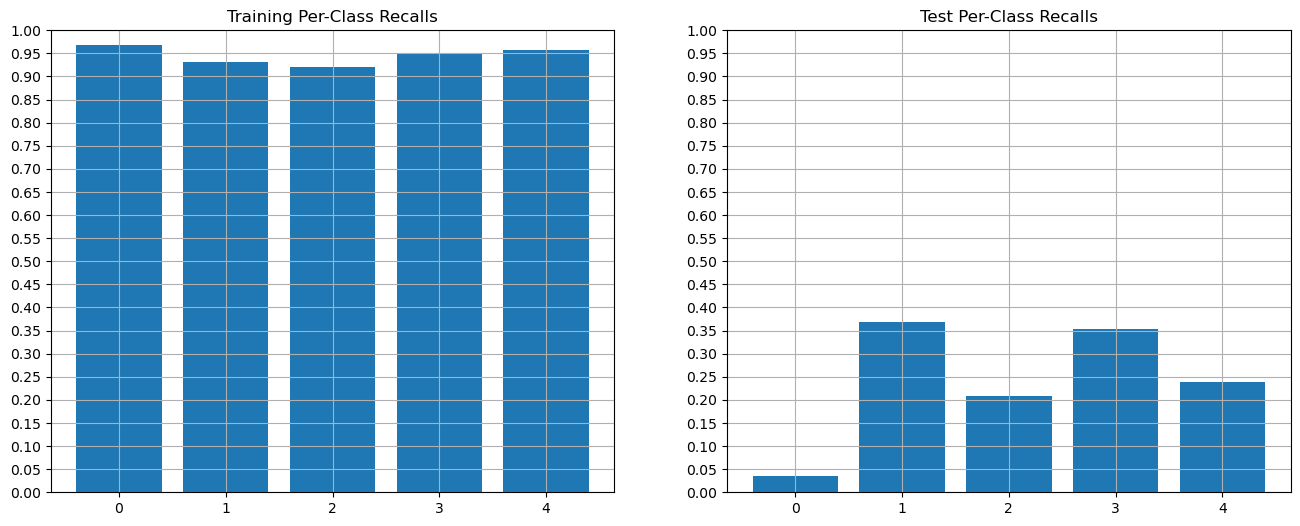

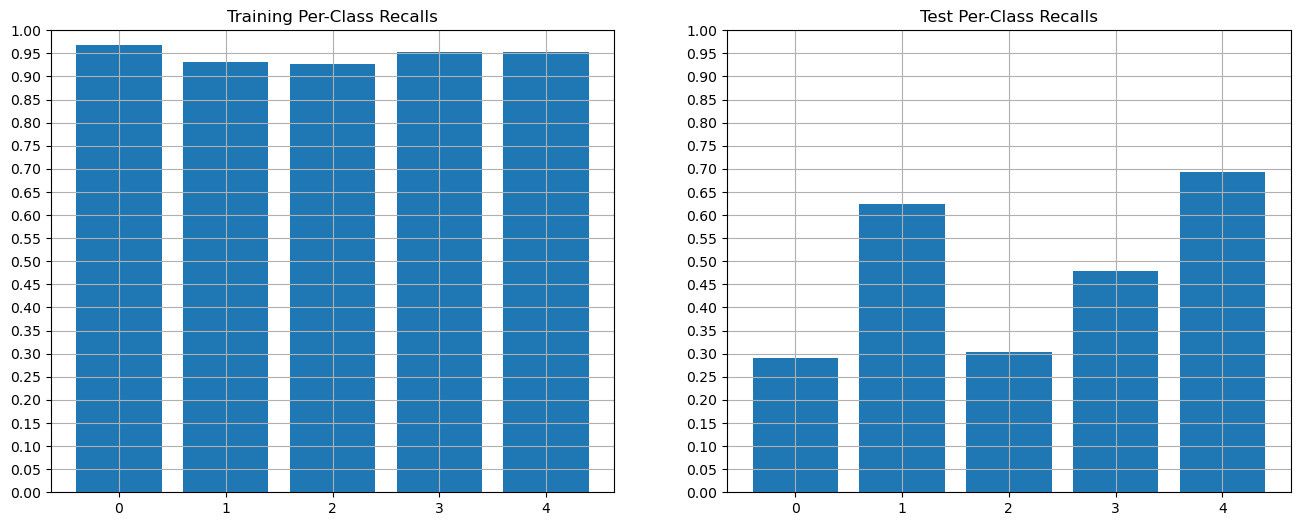

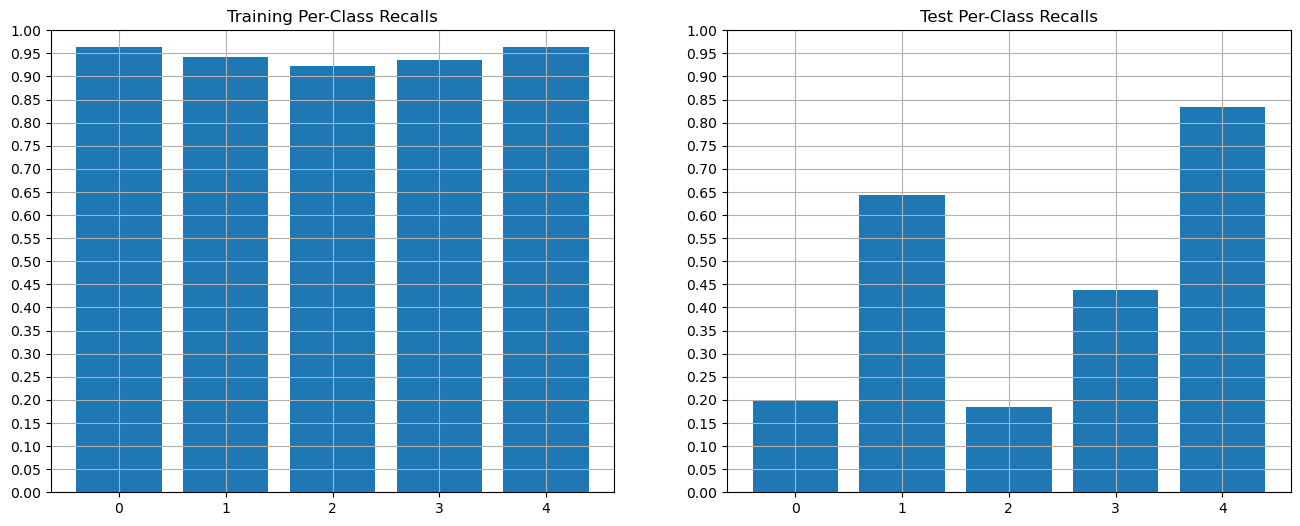

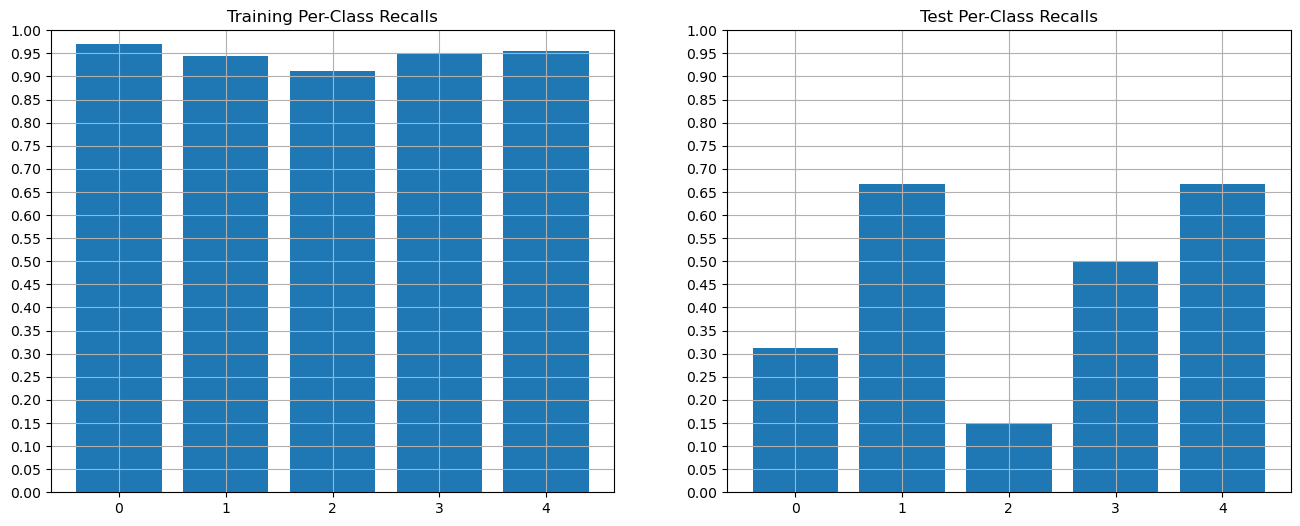

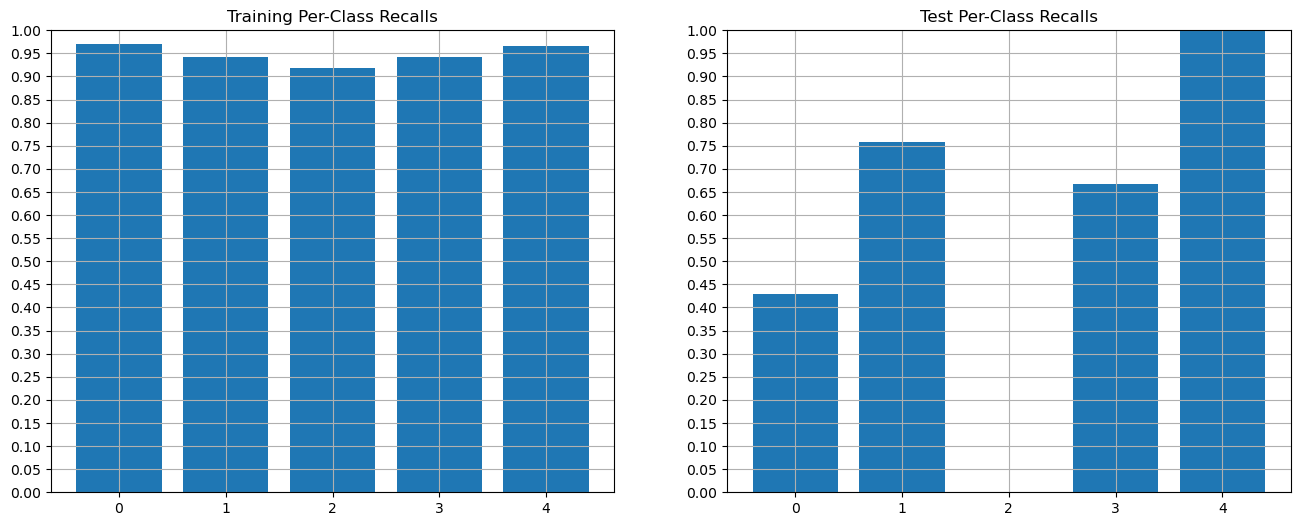

In [566]:
trains = []
tests = []
for tf in range(5):
    print(f'***** TAKE FIRST N={tf} *****')
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=tf)
    trains.append(train_bal)
    tests.append(test_bal)

Text(0, 0.5, 'Balanced Accuracy')

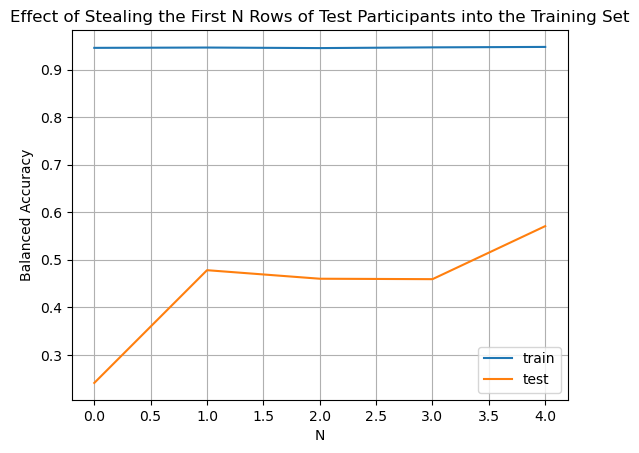

In [567]:
plt.figure()
plt.plot(range(5), trains, label='train')
plt.plot(range(5), tests, label='test')
plt.legend()
plt.grid()
plt.title('Effect of Stealing the First N Rows of Test Participants into the Training Set')
plt.xlabel('N')
plt.ylabel('Balanced Accuracy')

In [532]:
combined, merge_result = dp.combine(
    phq9, 
    dailies=[
        ('locations', locations), 
        # ('mobility', mobility),
        # ('phone', phone)
    ], 
    constants=[
        demographics
    ],
    prev_phq9=True,
    daily_reduction=['mean']
)

combined

,participant_id,date,target,prev_target,has_phq9,has_locations,automotive_mean,consumer_goods_mean,dining_out_mean,education_mean,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,2016-08-21,0.0,0.0,True,False,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,2016-08-29,0.0,0.0,True,False,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,2016-09-04,0.0,4.0,True,False,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,2016-09-11,0.0,0.0,True,False,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,2016-08-29,3.0,0.0,True,False,0.0,0.0,0.000000,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,ES05073,2017-02-05,2.0,1.0,True,True,0.0,0.0,0.000801,0.0,...,0,1,0,0,0,1,0,0,0,0
1157,ES05073,2017-02-19,2.0,1.0,True,True,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,1,0,0,0,0
1158,ES05073,2017-02-26,0.0,1.0,True,True,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,1,0,0,0,0
1159,ES05073,2017-03-12,4.0,1.0,True,True,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,1,0,0,0,0


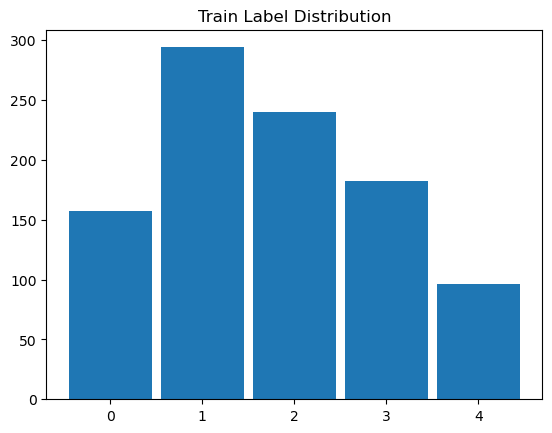

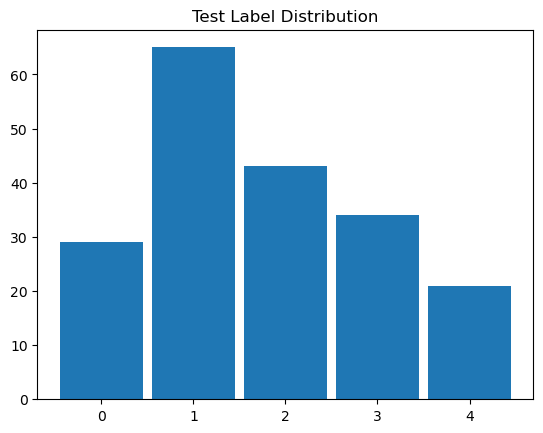

In [379]:

if TYPE == 'classification':
    plt.figure()
    plt.hist(y_train, bins=np.arange(-0.5, 4.6), rwidth=0.9)
    plt.title('Train Label Distribution')

    plt.figure()
    plt.hist(y_test, bins=np.arange(-0.5, 4.6), rwidth=0.9)
    plt.title('Test Label Distribution')

(array([  3.,   6.,  42., 146.,   0., 352., 162.,  31.,   5.,   1.]),
 array([-5. , -4.2, -3.4, -2.6, -1.8, -1. , -0.2,  0.6,  1.4,  2.2,  3. ]),
 <BarContainer object of 10 artists>)

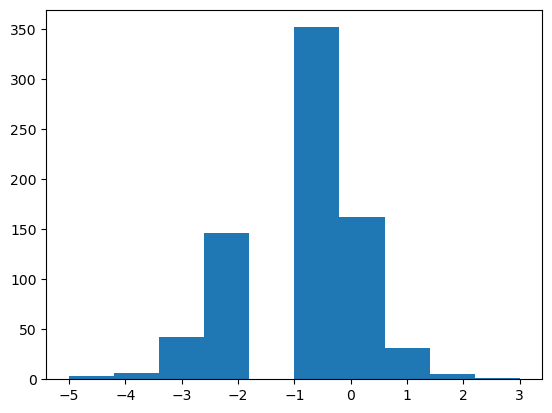

In [346]:
import matplotlib.pyplot as plt
plt.hist(y_train)

In [229]:
phq9.participant_id.unique().size
combined.participant_id.unique().size

285

In [500]:
def testf(df, method=['mean', 'std']):
    from collections import defaultdict
    inds = dp._group_by_phq9(df)
    
    def has_filt(col):
        return col.startswith('has_')
    
    def feature_filt(col):
        return col != 'target' and not col.startswith('has_')
    
    aggdict = {
        'target': 'last',
        **{c: 'max' for c in df.columns if has_filt(c)},
        **{c: method for c in df.columns if feature_filt(c)}
    }
    
    aggframe = df.groupby(inds).agg(aggdict)
    
    subcols = defaultdict(list)
    for name, sub in aggframe.columns.to_flat_index():
        subcols[name].append(sub)
        
    def rename_col(col):
        name, sub = col
        if len(subcols[name]) == 1:
            return name
        else:
            return '_'.join([name, sub])
    
    aggframe.columns = [rename_col(c) for c in aggframe.columns.to_flat_index()]
    return aggframe
    
d = merge_result.drop(columns=['date'])

a = d.groupby('participant_id').apply(testf)
k = 'home'
# a[~a['mean'].isna()]
# a.columns = ['_'.join(c) for c in a.columns.to_flat_index()]
a

target  has_phq9  has_locations  automotive_mean  \
participant_id                                                       
BLUE-00048     0     0.0      True          False              NaN   
BLUE-00050     0     1.0      True          False              NaN   
               1     0.0      True          False              NaN   
               2     0.0      True          False              NaN   
               3     0.0      True          False              NaN   
...                  ...       ...            ...              ...   
YELLOW-00262   2     1.0      True          False              NaN   
YELLOW-00263   0     2.0      True          False              NaN   
               1     1.0      True          False              NaN   
               2     1.0      True          False              NaN   
               3     1.0      True          False              NaN   

                  automotive_std  consumer_goods_mean  consumer_goods_std  \
participant_id                                                              
BLUE-00048     0             NaN                  NaN                 NaN   
BLUE-00050     0             NaN                  NaN                 NaN   
               1             NaN                  NaN                 NaN   
               2             NaN                  NaN                 NaN   
               3             NaN                  NaN                 NaN   
...                          ...                  ...                 ...   
YELLOW-00262   2             NaN                  NaN                 NaN   
YELLOW-00263   0             NaN                  NaN                 NaN   
               1             NaN                  NaN                 NaN   
               2             NaN                  NaN                 NaN   
               3             NaN                  NaN                 NaN   

                  dining_out_mean  dining_out_std  education_mean  ...  \
participant_id                                                     ...   
BLUE-00048     0              NaN             NaN             NaN  ...   
BLUE-00050     0              NaN             NaN             NaN  ...   
               1              NaN             NaN             NaN  ...   
               2              NaN             NaN             NaN  ...   
               3              NaN             NaN             NaN  ...   
...                           ...             ...             ...  ...   
YELLOW-00262   2              NaN             NaN             NaN  ...   
YELLOW-00263   0              NaN             NaN             NaN  ...   
               1              NaN             NaN             NaN  ...   
               2              NaN             NaN             NaN  ...   
               3              NaN             NaN             NaN  ...   

                  place_of_worship_mean  place_of_worship_std  repair_mean  \
participant_id                                                               
BLUE-00048     0                    NaN                   NaN          NaN   
BLUE-00050     0                    NaN                   NaN          NaN   
               1                    NaN                   NaN          NaN   
               2                    NaN                   NaN          NaN   
               3                    NaN                   NaN          NaN   
...                                 ...                   ...          ...   
YELLOW-00262   2                    NaN                   NaN          NaN   
YELLOW-00263   0                    NaN                   NaN          NaN   
               1                    NaN                   NaN          NaN   
               2                    NaN                   NaN          NaN   
               3                    NaN                   NaN          NaN   

                  repair_std  supermarket_mean  supermarket_std  transit_mean  \
participant_id                                

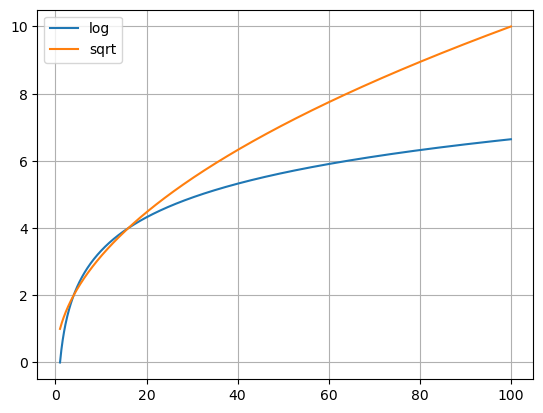

In [473]:
x = np.linspace(1, 100, 1000)
l = np.log2(x)
s = np.sqrt(x)

plt.figure()
plt.plot(x, l, label='log')
plt.plot(x, s, label='sqrt')
plt.legend()
plt.grid()


In [399]:
train_csv, test_csv = dp.train_test_split_exp(combined, 0.15, random_state=SEED, test_take_first=1)
a = test_csv.groupby('participant_id').head(1)
b = test_csv.groupby('participant_id').tail(-1)

In [220]:
x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15)
x_train.shape

(1008, 42) (153, 42)
0.14728682170542637


In [262]:
passive_mobility = dp.load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
passive_mobility

,participant_id,dt_passive,came_to_work,distance_active,distance_high_speed_transportation,distance_powered_vehicle,distance_walking,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance
0,EN00538,2016-11-14,1.0,6284.6,0.0,0.0,5420.4,8,0.783,0.0,9.733,0.000,11.750,6.833,1.517,-5.261
1,EN00538,2016-11-15,1.0,15960.1,0.0,0.0,7120.3,24,1.733,0.0,0.133,0.000,20.133,3.833,2.117,-5.440
2,EN00538,2016-11-16,1.0,4359.7,0.0,9656.3,3456.6,12,0.567,0.0,0.167,0.183,11.767,4.817,0.917,-4.209
3,EN00538,2016-11-17,1.0,22387.9,0.0,1143.0,9809.7,16,2.583,0.0,0.200,0.050,25.883,17.900,2.467,-5.122
4,EN00538,2016-11-18,1.0,45277.7,0.0,22332.9,5856.4,24,5.500,0.0,0.167,0.550,16.467,3.967,1.467,-4.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15351,EN05215,2016-11-25,0.0,10737.4,0.0,2685.7,0.0,2,0.783,0.0,5.567,0.083,0.000,0.000,0.000,-3.984
15352,EN05215,2016-11-26,1.0,3794.3,0.0,0.0,1844.3,7,0.350,0.0,2.683,0.000,10.717,4.667,0.383,-4.763
15353,EN05215,2016-11-27,1.0,1949.1,0.0,0.0,241.8,5,0.300,0.0,14.083,0.000,20.683,20.000,0.083,-5.478
15354,EN05215,2016-11-28,0.0,3113.3,0.0,5350.6,1241.7,5,0.350,0.0,0.250,0.183,27.117,27.117,0.267,-4.361


#### Random Forest Trial

In [334]:
combined # combined.loc[:, 'automotive':'work']

,participant_id,target,working,income_satisfaction,income_lastyear,age,gen_Female,gen_Male,martial_Married/Partner,martial_Separated/Widowed/Divorced,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,3.0,1.0,2.0,1.0,51.0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,ES05073,2.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1157,ES05073,2.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1158,ES05073,0.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1159,ES05073,4.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [277]:
df = merge_result # merge_result.reindex(sorted(merge_result.columns), axis=1)
df[df.participant_id == 'EN00041']

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,has_mobility
4180,EN00041,2016-08-19,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4152,EN00041,2016-09-02,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3723,EN00041,2016-09-09,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4839,EN00041,2016-09-12,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.200,0.000,9.983,0.000,5.700,3.900,0.700,-4.662,True
17394,EN00041,2016-09-13,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,0.217,0.000,3.483,2.000,15.400,12.350,0.500,-1.731,True
17395,EN00041,2016-09-14,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.067,0.900,1.283,3.200,14.600,14.600,1.083,0.437,True
4840,EN00041,2016-09-15,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.267,0.000,5.267,0.067,17.467,1.200,0.650,-5.045,True
4413,EN00041,2016-09-16,0.0,True,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.950,0.000,1.667,1.050,17.583,16.017,0.917,-2.715,True
4841,EN00041,2016-09-17,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.667,0.000,3.450,0.183,18.100,13.633,0.600,-4.039,True
4842,EN00041,2016-09-18,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.800,0.000,15.600,0.467,16.317,3.467,0.717,-2.967,True


In [300]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
s = phq9.loc[:, 'phq9_1':'phq9_9'].sum(axis=1)

In [279]:
merge_result

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,has_mobility
0,BLUE-00048,2014-08-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,BLUE-00050,2014-08-23,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,BLUE-00050,2014-08-30,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,BLUE-00050,2014-09-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,BLUE-00050,2014-09-22,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3623,YELLOW-00263,2014-12-17,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3624,YELLOW-00263,2014-12-24,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3625,YELLOW-00263,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [321]:
a = phq9.groupby('participant_id').apply(lambda x: x['target'].shift(1))
b = pd.DataFrame()
a = a.reset_index(drop=True)
b['target'] = a
b

,target
0,NaN
1,NaN
2,1.0
3,0.0
4,0.0
...,...
4786,1.0
4787,NaN
4788,2.0
4789,1.0
